In [24]:
# Configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
import os
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from datetime import datetime
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report
import sklearn.metrics as skm
import numpy as np
import matplotlib.pyplot as plt

In [66]:
def prepare_dataset(X_dataset, y_dataset, classes, n_samples):
    if n_samples is None:
        img_samples = X_dataset.shape[0]
    else:
        img_samples = n_samples

    df_aux = pd.DataFrame(columns=['id', 'label'])

    list_aux = []

    for i in range(img_samples):
        nm_file = str(i)+'-'+str([classes[x] for x in y_dataset[i]]).strip('[]').strip('\'')+'.'+'png'
        sample = {'id':nm_file, 'label':str([classes[x] for x in y_dataset[i]]).strip('[]').strip('\'')}
        list_aux.append(sample)

    return pd.concat([df_aux, pd.DataFrame(list_aux)], ignore_index=True)


def create_files(X_dataset, y_dataset, classes, dir, n_samples):
    if n_samples is None:
        img_samples = X_dataset.shape[0]
    else:
        img_samples = n_samples

    for i in range(img_samples):
        nm_file = str(i)+'-'+str([classes[x] for x in y_dataset[i]]).strip('[]').strip('\'')+'.'+'png'
        img = X_dataset[i]
        plt.imsave(dir + nm_file, img)


def create_directory(dir):
    if os.path.exists(dir):
        for file in os.listdir(dir):
            os.remove(dir+file)
    else:
        os.makedirs(dir)


def plot_loss(history):  
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Gráfico loss X epoch')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

In [26]:
from keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [27]:
train_dir = "./train/"
test_dir = "./test/" 

create_directory(train_dir)
create_directory(test_dir)

In [28]:
train_samples = 2500 #X_train.shape[0]

create_files(X_train, y_train, cifar10_classes, train_dir, train_samples)

train_df = prepare_dataset(X_train, y_train, cifar10_classes, train_samples)

train_df.head()

,id,label
0,0-frog.png,frog
1,1-truck.png,truck
2,2-truck.png,truck
3,3-deer.png,deer
4,4-automobile.png,automobile


In [29]:
test_samples = 500 #X_test.shape[0]

create_files(X_test, y_test, cifar10_classes, test_dir, test_samples)

test_df = prepare_dataset(X_test, y_test, cifar10_classes, test_samples)

test_df.head()

,id,label
0,0-cat.png,cat
1,1-ship.png,ship
2,2-ship.png,ship
3,3-airplane.png,airplane
4,4-frog.png,frog


label
deer          262
bird          255
ship          254
horse         253
airplane      253
frog          250
truck         250
cat           244
automobile    243
dog           236
Name: count, dtype: int64


<Axes: title={'center': 'Dados para Treinamento por classe'}, xlabel='label'>

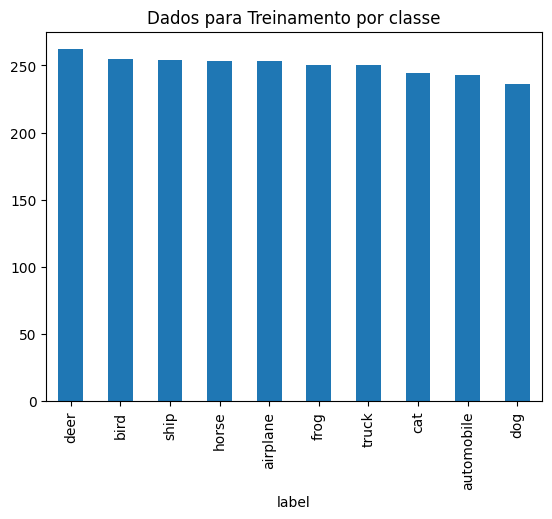

In [30]:
print((train_df['label']).value_counts())
train_df['label'].value_counts().plot.bar(title='Dados para Treinamento por classe')

label
ship          57
airplane      57
truck         56
frog          54
bird          51
cat           49
dog           48
horse         47
automobile    41
deer          40
Name: count, dtype: int64


<Axes: title={'center': 'Dados para Teste por classe'}, xlabel='label'>

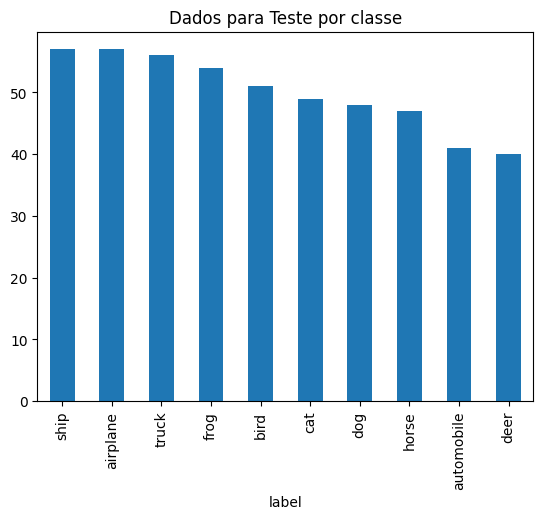

In [31]:
print((test_df['label']).value_counts())
test_df['label'].value_counts().plot.bar(title='Dados para Teste por classe')

In [32]:
print('Total de imagens para treinamento: %s' % len(os.listdir(train_dir)))
print('Total de imagens para teste      : %s' % len(os.listdir(test_dir)))

Total de imagens para treinamento: 2500
Total de imagens para teste      : 500


Classes: ['frog', 'truck', 'truck', 'deer', 'automobile']


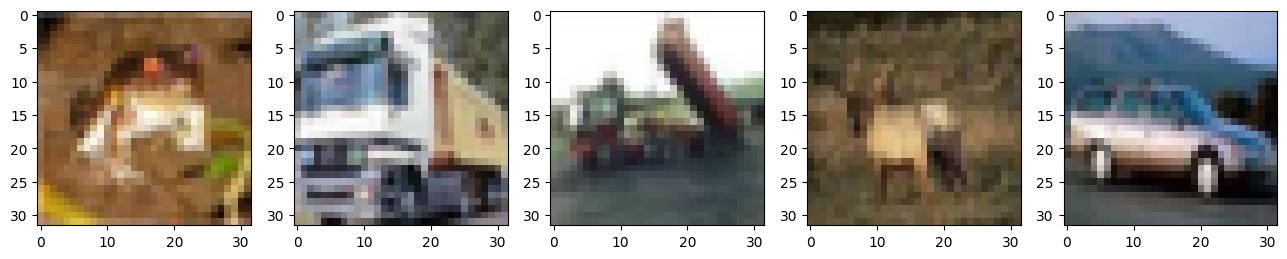

In [33]:
fig, x = plt.subplots(1, 5)
fig.set_size_inches(16, 6)

print('Classes: ' + str([cifar10_classes[x[0]] for x in y_train[0:5]]))

for i in range(5):
    image = X_train[i]
    x[i].imshow(image)
plt.show()

In [34]:
train_datagen=ImageDataGenerator(rescale=1.0/255.0,
                                validation_split=0.25)

train_generator=train_datagen.flow_from_dataframe(
dataframe=train_df,
directory=train_dir,
x_col="id",
y_col="label",
subset="training",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(32,32))

valid_generator=train_datagen.flow_from_dataframe(
dataframe=train_df,
directory=train_dir,
x_col="id",
y_col="label",
subset="validation",
batch_size=32,
seed=42,
shuffle=True,
class_mode="categorical",
target_size=(32,32))

Found 1875 validated image filenames belonging to 10 classes.
Found 625 validated image filenames belonging to 10 classes.


In [35]:
test_datagen=ImageDataGenerator(rescale=1.0/255.0)

test_generator=test_datagen.flow_from_dataframe(
dataframe=test_df,
directory=test_dir,
x_col="id",
y_col="label",
batch_size=32,
seed=42,
shuffle=False,
class_mode="categorical",
target_size=(32,32))

Found 500 validated image filenames belonging to 10 classes.


In [36]:
train_step_size = train_generator.n//train_generator.batch_size
validation_step_size = valid_generator.n//valid_generator.batch_size

In [52]:
# Modelo 1

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(32,32,3), activation='relu'))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [53]:
history = model.fit_generator(generator=train_generator,
          steps_per_epoch=train_step_size,
          validation_data=valid_generator,
          validation_steps=validation_step_size,
          epochs=15)

Epoch 1/15
58/58 [==============================] - 4s 54ms/step - loss: 2.1318 - accuracy: 0.2046 - val_loss: 1.8468 - val_accuracy: 0.3339
Epoch 2/15
58/58 [==============================] - 3s 50ms/step - loss: 1.8394 - accuracy: 0.3272 - val_loss: 1.7025 - val_accuracy: 0.3849
Epoch 3/15
58/58 [==============================] - 3s 51ms/step - loss: 1.6260 - accuracy: 0.4145 - val_loss: 1.6186 - val_accuracy: 0.4079
Epoch 4/15
58/58 [==============================] - 3s 53ms/step - loss: 1.5062 - accuracy: 0.4596 - val_loss: 1.5558 - val_accuracy: 0.4457
Epoch 5/15
58/58 [==============================] - 3s 51ms/step - loss: 1.3634 - accuracy: 0.5019 - val_loss: 1.4472 - val_accuracy: 0.4753
Epoch 6/15
58/58 [==============================] - 3s 52ms/step - loss: 1.2083 - accuracy: 0.5600 - val_loss: 1.4325 - val_accuracy: 0.4720
Epoch 7/15
58/58 [==============================] - 3s 50ms/step - loss: 1.0402 - accuracy: 0.6283 - val_loss: 1.4479 - val_accuracy: 0.4803
Epoch 8/15
58

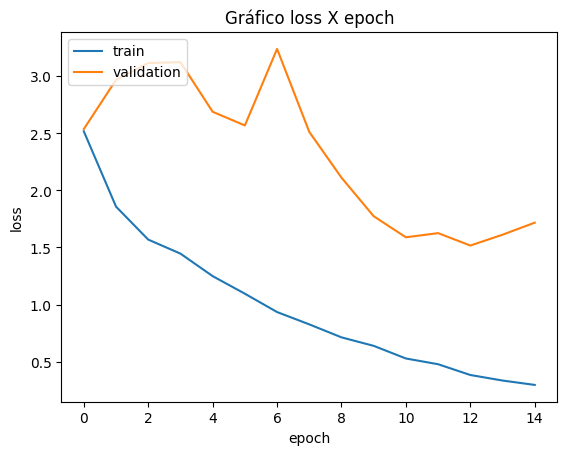

In [67]:
plot_loss(history)

In [55]:
loss, accuracy = model.evaluate_generator(test_generator)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.474000  ;  loss = 2.961858 


In [56]:
# Modelo 2

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(32,32,3), activation='relu'))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [57]:
history = model.fit_generator(generator=train_generator,
          steps_per_epoch=train_step_size,
          validation_data=valid_generator,
          validation_steps=validation_step_size,
          epochs=15)

Epoch 1/15
58/58 [==============================] - 4s 58ms/step - loss: 2.1938 - accuracy: 0.1541 - val_loss: 2.0962 - val_accuracy: 0.2303
Epoch 2/15
58/58 [==============================] - 3s 53ms/step - loss: 1.9061 - accuracy: 0.2941 - val_loss: 1.7751 - val_accuracy: 0.3405
Epoch 3/15
58/58 [==============================] - 3s 55ms/step - loss: 1.6921 - accuracy: 0.3684 - val_loss: 1.6431 - val_accuracy: 0.4145
Epoch 4/15
58/58 [==============================] - 4s 64ms/step - loss: 1.5835 - accuracy: 0.4254 - val_loss: 1.5652 - val_accuracy: 0.4243
Epoch 5/15
58/58 [==============================] - 4s 71ms/step - loss: 1.4587 - accuracy: 0.4721 - val_loss: 1.5533 - val_accuracy: 0.4359
Epoch 6/15
58/58 [==============================] - 4s 68ms/step - loss: 1.3698 - accuracy: 0.5117 - val_loss: 1.5422 - val_accuracy: 0.4441
Epoch 7/15
58/58 [==============================] - 4s 71ms/step - loss: 1.2923 - accuracy: 0.5165 - val_loss: 1.5480 - val_accuracy: 0.4523
Epoch 8/15
58

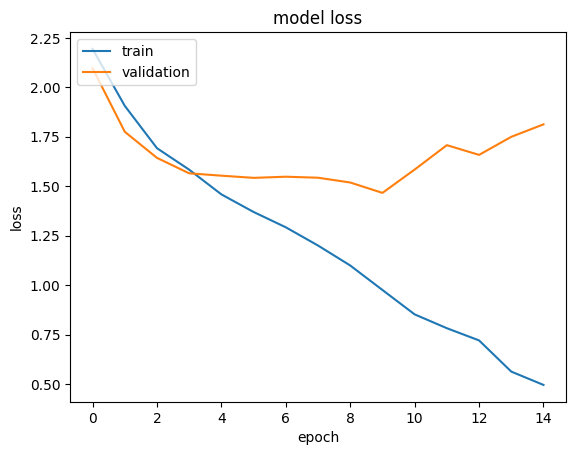

In [58]:
plot_loss(history)

In [59]:
loss, accuracy = model.evaluate_generator(test_generator)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.474000  ;  loss = 1.861945 


In [60]:
 # Modelo 3

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(32,32,3), activation='relu'))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [61]:
history = model.fit_generator(generator=train_generator,
          steps_per_epoch=train_step_size,
          validation_data=valid_generator,
          validation_steps=validation_step_size,
          epochs=15)

Epoch 1/15
58/58 [==============================] - 6s 86ms/step - loss: 2.5173 - accuracy: 0.2457 - val_loss: 2.5375 - val_accuracy: 0.0970
Epoch 2/15
58/58 [==============================] - 5s 83ms/step - loss: 1.8577 - accuracy: 0.3825 - val_loss: 2.9686 - val_accuracy: 0.1036
Epoch 3/15
58/58 [==============================] - 5s 84ms/step - loss: 1.5689 - accuracy: 0.4585 - val_loss: 3.1159 - val_accuracy: 0.0921
Epoch 4/15
58/58 [==============================] - 5s 82ms/step - loss: 1.4461 - accuracy: 0.4981 - val_loss: 3.1239 - val_accuracy: 0.1069
Epoch 5/15
58/58 [==============================] - 5s 89ms/step - loss: 1.2489 - accuracy: 0.5741 - val_loss: 2.6889 - val_accuracy: 0.1711
Epoch 6/15
58/58 [==============================] - 5s 79ms/step - loss: 1.0950 - accuracy: 0.6137 - val_loss: 2.5690 - val_accuracy: 0.2105
Epoch 7/15
58/58 [==============================] - 4s 75ms/step - loss: 0.9341 - accuracy: 0.6663 - val_loss: 3.2395 - val_accuracy: 0.1743
Epoch 8/15
58

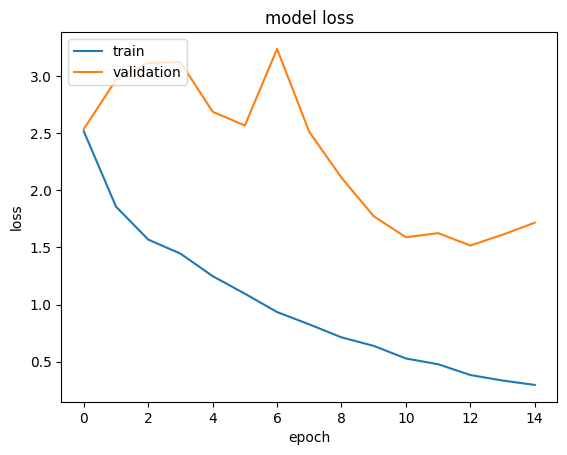

In [62]:
plot_loss(history)

In [64]:
loss, accuracy = model.evaluate_generator(test_generator)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

Test: accuracy = 0.470000  ;  loss = 1.769964 


In [ ]:
# MODELO PROPOSTO

model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(32,32,3), activation=('relu')))

model.add(layers.Conv2D(32, (3, 3), activation=('relu')))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(256), activation=('relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))

model.summary()

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#train_step_size = train_generator.n//train_generator.batch_size
#validation_step_size = valid_generator.n//valid_generator.batch_size

model.fit_generator(generator=train_generator,
          steps_per_epoch=train_step_size,
          validation_data=valid_generator,
          validation_steps=validation_step_size,
          epochs=15
)

In [ ]:
test_generator.reset()

count = 0
y_pred = list()
y_true = list()
class_names = cifar10_classes

for batch in test_generator:
    count+=1

    if count == len(test_generator)+1:
        break
    else:
        images = batch[0]
        labels = batch[1]
        predictions = model.predict(images)

        for i in range(len(images)):
            image = images[i]
            label = labels[i]
            prediction = predictions[i]

            predicted_class = np.argmax(prediction)
            probability = prediction[predicted_class]
            class_name = class_names[int(predicted_class)]
            y_pred.append(class_name)

            labeled_class = np.argmax(label)
            label = class_names[int(labeled_class)]
            y_true.append(label)

In [ ]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":y_pred})
results.to_csv("results_deep_learning.csv",index=False)

In [ ]:
loss, accuracy = model.evaluate_generator(test_generator)
print("Test: accuracy = %f  ;  loss = %f " % (accuracy, loss))

In [ ]:
accuracy = skm.accuracy_score(y_true, y_pred)
precision = skm.precision_score(y_true, y_pred, average='weighted')
recall = skm.recall_score(y_true, y_pred, average='weighted')
f1score = skm.f1_score(y_true, y_pred, average='weighted')

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1score)

In [ ]:
cnf_matrix = confusion_matrix(y_true, y_pred, labels=class_names)
np.set_printoptions(precision=2)

fig, ax = plt.subplots(figsize=(5, 5))
cax = ax.matshow(cnf_matrix, cmap=plt.cm.Blues, alpha=0.3, interpolation = 'nearest')
plt.gca().xaxis.tick_bottom()

tick_marks = np.arange(len(cifar10_classes))
plt.xticks(tick_marks, cifar10_classes, rotation=45)
plt.yticks(tick_marks, cifar10_classes)

for i in range(cnf_matrix.shape[0]):
    for j in range(cnf_matrix.shape[1]):
        ax.text(x=j, y=i,s=cnf_matrix[i, j], va='center', ha='center')

fig.colorbar(cax)

plt.xlabel('Predição', fontsize=13)
plt.ylabel('Real', fontsize=13)
plt.title('Matriz de Confusão', fontsize=18)
plt.show()

In [ ]:
'''

model_dir = "./trained_models/"
create_directory(model_dir)

# obtendo a data e hora atual
now = datetime.now()

# Definição do formato
format = '%Y-%m-%dT%H%M'

# Converter a data e hora em uma string com o formato especificado
formatted_datetime = now.strftime(format)

model_name = 'trained_model_deep_learning' + formatted_datetime + '.h5'

# salvando o modelo
model.save("%s/%s" % (model_dir, model_name))
print("Modelo salvo com o nome: ", model_name)

'''

In [ ]:
'''

model_loaded = keras.models.load_model("%s/%s" % (model_dir, model_name))
print("Modelo %s carregado com sucesso" % (model_name))

'''

In [ ]:
'''

test_generator.reset()

count = 0
y_pred = list()
y_true = list()
class_names = cifar10_classes

# Loop do data generator de teste que contem as imagens
for batch in test_generator:

    count+=1

    # Condição de saída do loop. Só executaremos o modelo em algumas imagens
    if count == len(test_generator)+1:
        break

    else:
        # Pegando a imagem e o label
        images = batch[0]
        labels = batch[1]

        # Previsão
        predictions = model_loaded.predict(images)

        # Visualização da imagem
        for i in range(len(images)):

            image = images[i]
            label = labels[i]

            prediction = predictions[i]

            # Converte o array de previsão para visualizar a classe e a probabilidade
            predicted_class = np.argmax(prediction)
            probability = prediction[predicted_class]

            labeled_class = np.argmax(label)
            label = class_names[int(labeled_class)]

            y_true.append(label)

            # Faz o DE-PARA da probabilidade com o tipo de classe da previsão
            # class_name = 'dog' if prediction >= 0.5 else 'cat'

            class_name = class_names[int(predicted_class)]

            y_pred.append(class_name)

'''

In [ ]:
'''

filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":y_pred})
results.to_csv("results_deep_learning_trained.csv",index=False)

'''